# Pygimli synthetic data study

## written by Anton Ziegon

<div class="alert alert-info">
<h4>Summary of this script</h4>

In this script the simplified geologic model (which was created in Gempy) is reproduced in pygimli. The Gempy model could not be used due to an error in the Gempy-to-pygimli-function (not yet fixed). Forward calculations of geophysical methods (ERT, TraveltimeTomography) are performed on the resulting Model/Mesh. The resulting synthetic data will be inverted in the following Notebook ``RM_pygimli_inversion.ipynb``.

In [17]:
# Importing pygimli
import  pygimli                 as     pg
import  pygimli.meshtools       as     mt
from    pygimli.physics         import ert
from    pygimli.physics         import TravelTimeManager

# Importing auxiliary libraries
import  numpy                   as     np
import  pandas                  as     pd
import  matplotlib.pyplot       as     plt
from    matplotlib.patches      import PathPatch 
import  os

%matplotlib inline

# Setting options
seed_val = 420
np.random.seed(seed_val)
pd.set_option('precision', 2)

## Parameter settings

In [33]:
# Material properties
class Soil:
    rho = 100       # electrical resistivity in Ohmm
    v   = 650       # seismic velocity in m/s
    k   = 10**-10   # magnetic susceptibility
    
class SS:
    rho = 1200      # electrical resistivity in Ohmm
    v   = 3000      # seismic velocity in m/s (value related to sandstone with ~28% porosity)
    k   = 2*10**-4  # magnetic susceptibility
    
class CSS:
    rho = 3500      # electrical resistivity in Ohmm
    v   = 3600      # seismic velocity in m/s (value related to sandstone with ~20% porosity)
    k   = 4*10**-4  # magnetic susceptibility
    
class basement:
    rho = 10**8     # electrical resistivity in Ohmm
    v   = 4500      # seismic velocity in m/s (value related to sandstone with ~10% porosity)
    k   = 8*10**-4  # magnetic susceptibility
    
class Diatreme:
    rho = 10**5     # electrical resistivity in Ohmm
    v   = 2000      # seismic velocity in m/s
    k   = 0.12      # magnetic susceptibility
    
class ERT:
    e_start   = 5     # first electrode position
    e_end     = 125   # last electrode position
    n_elecs   = 121   # number of electrodes
    noiselev  = 1
    noiseabs  = 1e-6
    save_data = True
    
class TT:
    sensor_start = -10   # first geophone position
    sensor_end   = 140 # last geophone position
    n_sensors    = 76  # number of geophones
    noiselev     = 1e-2
    noiseabs     = 1e-3
    save_data    = True

## Creating Mesh with pygimli based on Gempy models 
(Loading model mesh did not work - error not fixed yet)

In [19]:
# Create layered subsurface
world = mt.createWorld([-20,-70], [150, 0], layers=[-10,-30,-60])

# Create surface points for Diatreme
pnts = [[20,-20], [30,-5], [50,-9], [70,-5], [80,-20]]
top = mt.createPolygon(pnts, addNodes=5, interpolate="spline")
left = mt.createLine([30,-70], pnts[0])
right = mt.createLine([70,-70], pnts[-1])

# Combine Diatreme and layered subsurface
geom = world + top + left + right

# Add RegionMarkers
for y in -9, -20, -50, -65:
    geom.addRegionMarker([50, y], 5)
for marker, y in enumerate([-20, -50, -65]):
    geom.addRegionMarker([100, y], marker + 2)

# Create mesh
geom_mesh = mt.createMesh(geom, area=10)
#mt.exportPLC(geom_mesh, 'mesh_combinedmodel.poly')

#Append a boundary region for forward calculations
#world_with_boundary = pg.meshtools.appendTriangleBoundary(world, marker=1, xbound=10, ybound=10)

Text(0.5, 1.0, 'Resulting Mesh')

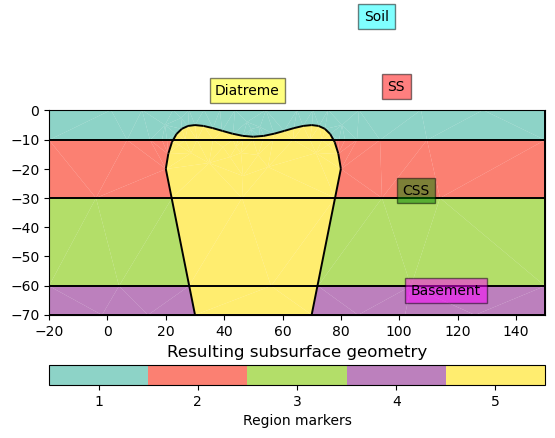

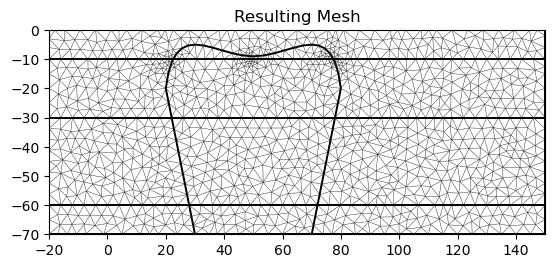

In [20]:
# Visualization of geometry
pg.show(geom)
plt.title('Resulting subsurface geometry')
# Notes
plt.text(2.8, 18.2, 'Soil', horizontalalignment='center', bbox=dict(facecolor='cyan', alpha=0.5))
plt.text(3, 14.7, 'SS', horizontalalignment='center', bbox=dict(facecolor='red', alpha=0.5))
plt.text(3.2, 9.5, 'CSS', horizontalalignment='center', bbox=dict(facecolor='green', alpha=0.5))
plt.text(3.5, 4.5, 'Basement', horizontalalignment='center', bbox=dict(facecolor='magenta', alpha=0.5))
plt.text(1.5, 14.5, 'Diatreme', horizontalalignment='center', bbox=dict(facecolor='yellow', alpha=0.5))
plt.savefig('combined_mesh.pdf')

# Visualization of mesh
pg.show(geom_mesh)
plt.title('Resulting Mesh')

### Mapping resistivity values to formations

(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x2b19eccca00>)

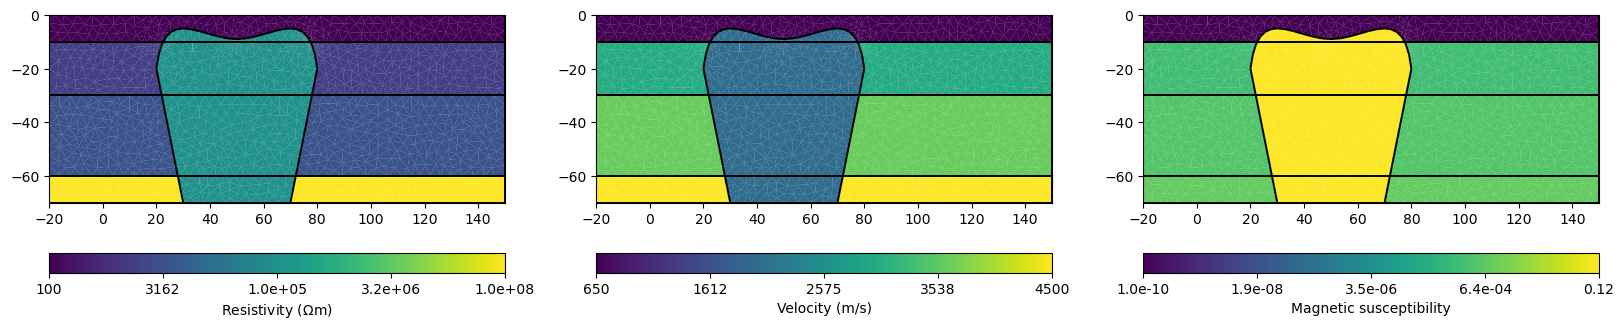

In [21]:
#Mapping typical matrial properties to units
rhomap = [[1,Soil.rho], [2,SS.rho], [3,CSS.rho], [4,basement.rho], [5,Diatreme.rho]]
vmap = [[1,Soil.v],[2,SS.v],[3,CSS.v],[4,basement.v], [5,Diatreme.v]]
kmap = [[1,Soil.k],[2,SS.k], [3,CSS.k], [4,basement.k], [5,Diatreme.k]]

#mesh = mt.createMesh(world)
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20, 20))   
pg.show(geom_mesh, ax=ax1, data = rhomap, label = pg.unit('res'), colorBar =True, logScale=True)
pg.show(geom_mesh, ax=ax2, data = vmap, label = pg.unit('vel'), colorBar =True, logScale=False)
pg.show(geom_mesh, ax=ax3, data = kmap, label = 'Magnetic susceptibility', colorBar =True, logScale=True)

### ERT forward calculation

13/12/22 - 20:41:40 - pyGIMLi - INFO - Calculate geometric factors.


relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Data error estimate (min:max)  0.010000176680440098 : 0.018941973991497513


13/12/22 - 20:41:41 - pyGIMLi - INFO - Calculate geometric factors.
13/12/22 - 20:41:42 - pyGIMLi - INFO - Calculate geometric factors.


relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Data error estimate (min:max)  0.01000005962315603 : 0.01001803537279321
relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Data error estimate (min:max)  0.01000005962315603 : 0.010000508176457543


Text(0.5, 1.0, 'Refined mesh')

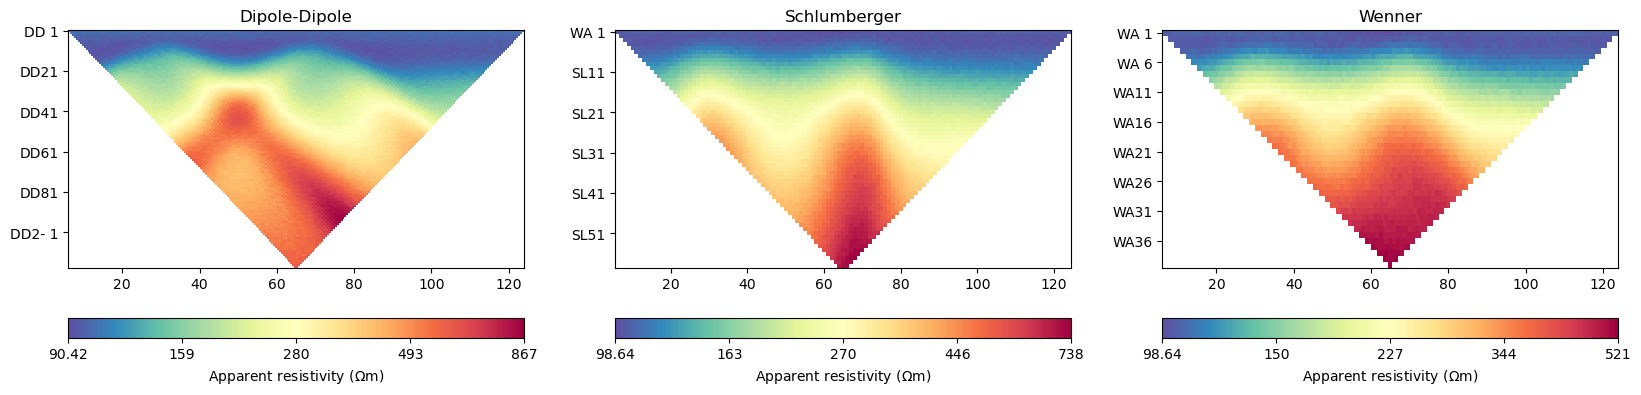

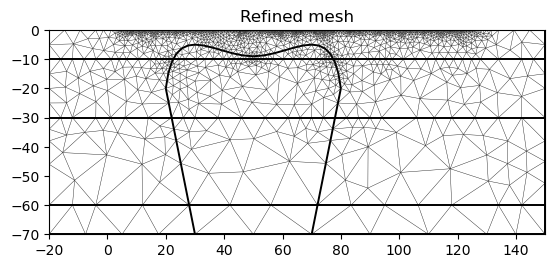

In [24]:
# Electrode configurations
ert_config = ['dd','slm','wa']

for con in ert_config:
    # Defining ERT measurement schemes
    ERT_scheme = ert.createData(elecs=np.linspace(start=ERT.e_start, stop=ERT.e_end, num=ERT.n_elecs), schemeName=con)
    
    # Create Nodes at electrode positions for improving numerical accuracy
    for s in ERT_scheme_dd.sensors():
        geom.createNode(s + [0.0, -0.2])
    ert_mesh = mt.createMesh(geom, quality=33)
    
    # Simulating data
    ert_data = ert.simulate(ert_mesh, res=rhomap, scheme=ERT_scheme, verbose=True,
                           noiseLevel=ERT.noiselev,noiseAbs=ERT.noiseabs, seed=seed_val)

    # Save the data for further use
    if ERT.save_data == True:
        ert_data.save('SyntheticData/ert_data_'+con+'.dat')


# Inspecting data
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20, 4))     
ert.show(ert.load('SyntheticData/ert_data_dd.dat'), ax=ax1)
ert.show(ert.load('SyntheticData/ert_data_slm.dat'), ax=ax2)
ert.show(ert.load('SyntheticData/ert_data_wa.dat'), ax=ax3)
ax1.set_title('Dipole-Dipole')
ax2.set_title('Schlumberger') 
ax3.set_title('Wenner') 

# Inspecting refined mesh
pg.show(ert_mesh)
plt.title('Refined mesh')

### Traveltime tomography

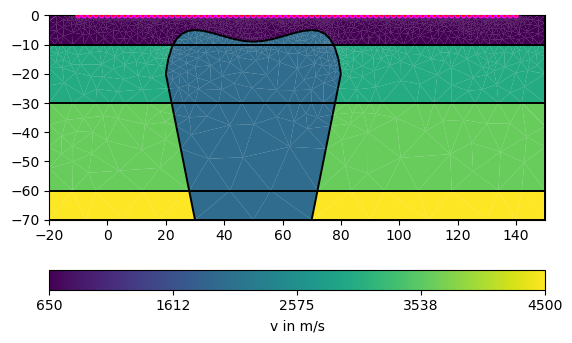

In [34]:
# Defining TT measurement schemes
TT_scheme = pg.physics.traveltime.createRAData(np.linspace(TT.sensor_start, TT.sensor_end, TT.n_sensors))

# Create Nodes at electrode positions for improving numerical accuracy
for s in TT_scheme.sensors():
    geom.createNode(s + [0.0, -0.2])
tt_mesh = mt.createMesh(geom, quality=33)

# Visual Inspection
ax, _ = pg.show(tt_mesh, vmap, colorBar=True, logScale=False, label='v in m/s')
pg.viewer.mpl.drawSensors(ax, TT_scheme.sensors(), diam=1.5, facecolor='red', edgecolor='magenta')

# Assign velocity to nodes
vp = np.array(tt_mesh.cellMarkers())
vp[vp == vmap[0][0]] = vmap[0][1]
vp[vp == vmap[1][0]] = vmap[1][1]
vp[vp == vmap[2][0]] = vmap[2][1]
vp[vp == vmap[3][0]] = vmap[3][1]
vp[vp == vmap[4][0]] = vmap[4][1]

13/12/22 - 20:47:26 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.


((<matplotlib.image.AxesImage at 0x2b18c54d2e0>,
  <matplotlib.colorbar.Colorbar at 0x2b18c494070>),
 None)

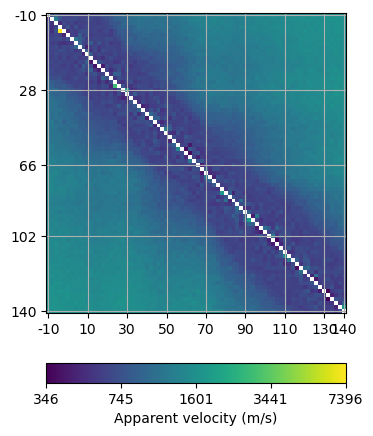

In [35]:
# Simulating data
mgr_tt = TravelTimeManager()
tt_data = mgr_tt.simulate(slowness=1.0 / vp, scheme=TT_scheme, mesh=tt_mesh,
                    noiseLevel=TT.noiselev, noiseAbs=TT.noiseabs, seed=seed_val,
                    verbose=True)
# Save for further use
if TT.save_data == True:
    tt_data.save('SyntheticData/tt_data.dat')

# Insecting data
mgr_tt.showData(tt_data)

<div class="alert alert-info">
<h4>Note:</h4>

The data is further used for an inversion in the parts below.

## Inversion of synthetic data

### ERT Inversion

... of Dipole-Dipole data

((<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x2b18c4f3370>), None)

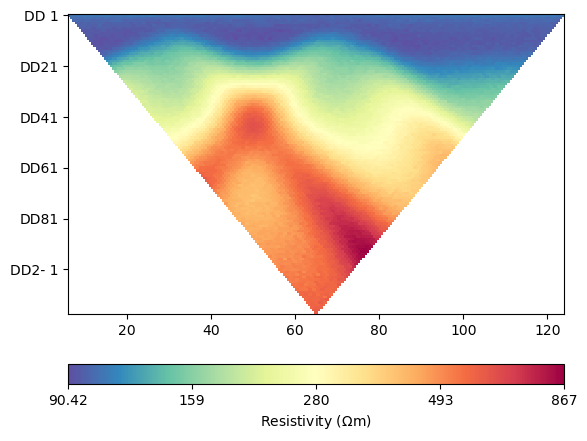

In [36]:
# Loading ERT Manager
mgr_dd = ert.ERTManager('SyntheticData/ert_data_dd.dat')

# Load data
ert_data_dd = ert.load('SyntheticData/ert_data_dd.dat')
mgr_dd.showData(ert_data_dd)

# Inverting data
inv = mgr_dd.invert(lam=20, secNodes=2, paraMaxCellSize=20, verbose=True)

### TT Inversion

In [37]:
# Invert data
vest = mgr_tt.invert(tt_data, secNodes=2, paraMaxCellSize=20, maxIter=15, verbose=True,
                  vTop=600, vBottom=4000, lam=50)
#np.testing.assert_array_less(mgr.inv.inv.chi2(), 1.1)

13/12/22 - 20:48:27 - pyGIMLi - INFO - Found 1 regions.
13/12/22 - 20:48:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
13/12/22 - 20:48:27 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.
13/12/22 - 20:48:27 - pyGIMLi - INFO - Create gradient starting model. 600: 4000
13/12/22 - 20:48:27 - pyGIMLi - INFO - Created startmodel from forward operator: [0.00137739 0.00100861 0.00162592 ... 0.00027202 0.00025778 0.00025   ]
13/12/22 - 20:48:27 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x000002B19FB920E0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000002B19FB8FD60>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000002B19FB8F4F0>
min/max (data): 2.7e-04/0.09
min/max (error): 2.04%/381%
min/max (start model): 2.5e-04/0.0017
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 1.5 (dPhi = 27.25%) lam: 50
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 1.22 (dPhi = 16.69%) lam: 50.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 1.08 (dPhi = 11.63%) lam: 50.0
--------------------------------------------------------------------------------
inv.iter 5 ... chi² = 1.05 (dPhi = 2.9%) lam: 50.0
------------------------------------

(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x2b19faf8c10>)

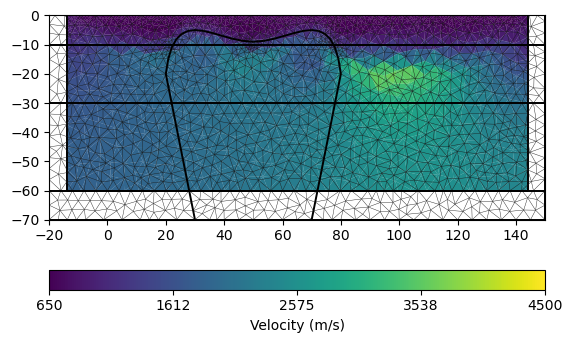

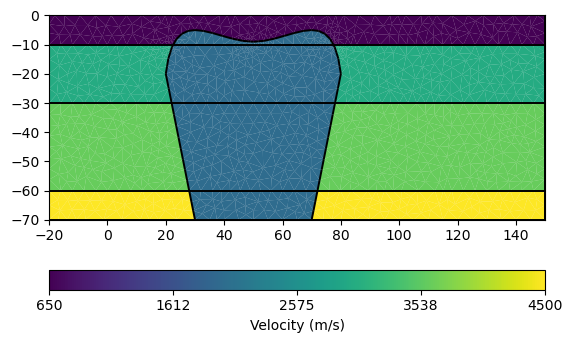

In [38]:
ax, _ = mgr_tt.showResult(cMin=min(vp), cMax=max(vp), logScale=False)
pg.show(geom_mesh, ax=ax, fillRegion=False, regionMarker=False)

fig,ax2 = plt.subplots()
pg.show(geom_mesh, ax=ax2, data = vmap, label = pg.unit('vel'), colorBar =True, logScale=False)

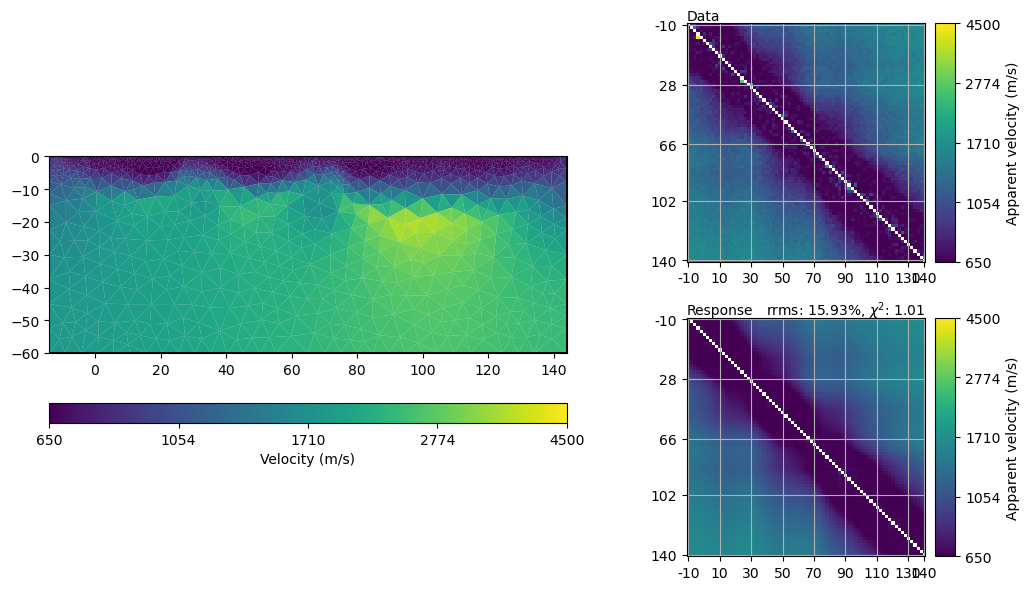

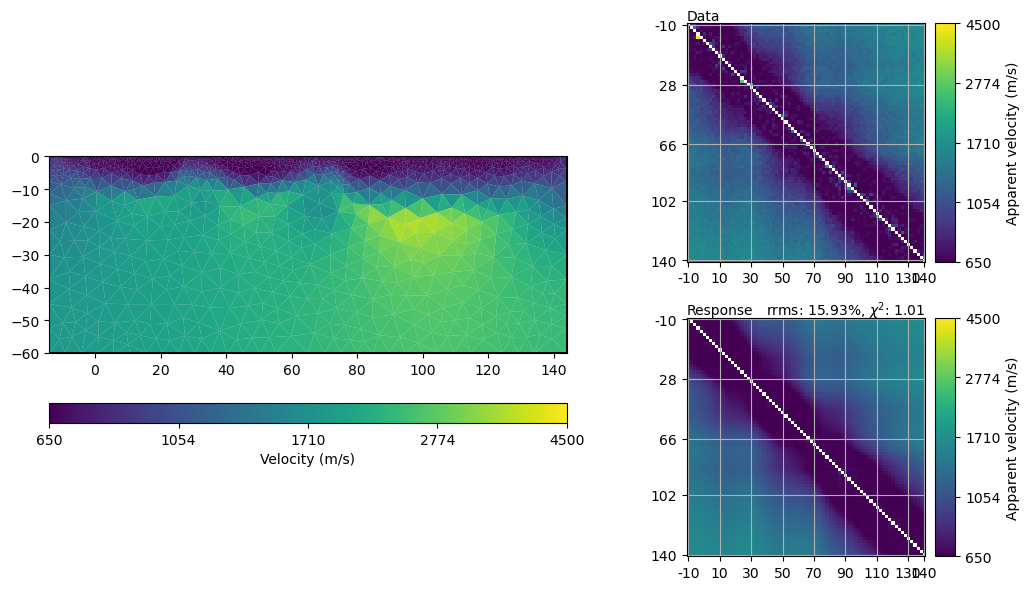

In [40]:
mgr_tt.showResultAndFit(cMin=min(vp), cMax=max(vp))